In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.keras.utils import plot_model

In [2]:
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError

## Model Evaluator Class 
#### to compare model of differenct configurations

In [13]:
class ModelEvaluator:
    __dict_models = {}
    __dict_prediction = {}
    __list_dict_eval_result = []
    __max_combinations = 24
    __reg_optimizers = ['SGD','ADM']
    __mae_calculator = MeanAbsoluteError()
    __mse_calculator = MeanSquaredError()
    
    def __init__(self,tn_X_train,tn_y_train,tn_X_test,tn_y_test):
        self.__tn_X_train = tn_X_train
        self.__tn_y_train = tn_y_train
        self.__tn_X_test = tn_X_test
        self.__tn_y_test = tn_y_test
    
    def __get_optimizer(self,opt):
        if opt == 'SGD':
            return tf.keras.optimizers.SGD()
        elif opt == 'ADM':
            return tf.keras.optimizers.Adam(learning_rate=0.01)
        else:
            return None
        
    def __predict(self,model):
        y_pred = model.predict(self.__tn_X_test)
        tn_y_pred = tf.constant(y_pred)
        tn_y_pred = tf.squeeze(tn_y_pred)
        return tn_y_pred
    
    def plot_prediction(self):        
        no_of_row = math.ceil(len(self.__dict_prediction)/3)
        fig, axis_matrix = plt.subplots(no_of_row, 3)
        fig.set_size_inches(18,4*no_of_row)
        ctr_model_id = 1
        for idx, axis in np.ndenumerate(axis_matrix):
            if ctr_model_id in self.__dict_prediction:
                model_name = 'Model-'+('0' if ctr_model_id <=9 else '')+str(ctr_model_id)
                tn_y_pred = self.__dict_prediction[ctr_model_id]
                axis.set_title(model_name)
                axis.scatter(tn_X_test,tn_y_test,c='g',label='Testing Data')
                axis.scatter(tn_X_test,tn_y_pred,c='r',label='Prediction')
                ctr_model_id = ctr_model_id + 1
        
    def get_predictions(self):
        return self.__dict_prediction
        
    def evaluate(self,hidden_layers=[1],neurons=[50],optimizers=['SGD'],epochs=[100]):
        tf.random.set_seed(42)
        
        no_combination = len(hidden_layers) * len(neurons) * len(optimizers) * len(epochs)
        if no_combination > self.__max_combinations:
            print('ERROR: No. of combination exceeds maximum limit - '+ str(self.__max_combinations))
            return
        else:
            print('INFO: No. of combination - '+ str(no_combination))
            
        # Clear result
        self.__dict_models = {}
        self.__list_dict_eval_result.clear()
        
        # Model Creation with all combinaton
        ctr_id = 1
        for opt in optimizers:
            for no_layers in hidden_layers:
                for no_neurons in neurons:                
                    for ep in epochs:
                        dict_eval_result = {}
                        model_name = 'Model-'+('0' if ctr_id <=9 else '')+str(ctr_id)
                        dict_eval_result['Id'] = ctr_id
                        dict_eval_result['Name'] = model_name
                        
                        # Model Creation
                        list_layers = []
                        for n in range(0,no_layers):
                            list_layers.append(tf.keras.layers.Dense(no_neurons,activation='relu'))
                        list_layers.append(tf.keras.layers.Dense(1)) 
                        model = tf.keras.Sequential(list_layers)
                        #model.name = model_name
                        
                        #Model Compilation
                        optimizer = self.__get_optimizer(opt)
                        model.compile(loss=tf.keras.losses.mae, # Mean absolute error
                                      optimizer=optimizer, # stochastic gradient descent
                                      metrics=['mae'])  
                        
                        # Fit the model
                        model.fit(tf.expand_dims(tn_X_train, axis=-1), tn_y_train, epochs=ep,verbose=0)
                        
                        # Prediction with test data
                        tn_y_pred = self.__predict(model)
                        self.__dict_prediction[ctr_id] = tn_y_pred
                        
                        # Error Calculation
                        mae = self.__mae_calculator(tn_y_test, tn_y_pred).numpy()
                        mse = self.__mse_calculator(tn_y_test, tn_y_pred).numpy()
                        dict_eval_result['Optimizer'] = opt
                        dict_eval_result['Hidden Layers'] = no_layers
                        dict_eval_result['Neurons Per Layer'] = no_neurons                        
                        dict_eval_result['Epochs'] = ep
                        dict_eval_result['Mean Absolute Error'] = mae
                        dict_eval_result['Mean Absolute Error'] = mae
                        dict_eval_result['Mean Square Error'] = mse
                        
                        print('INFO: Model Creation, Compilation, Fit process & Prediction done for - '+ model_name)    
                        
                        self.__dict_models[ctr_id] = model
                        self.__list_dict_eval_result.append(dict_eval_result)
                        ctr_id = ctr_id + 1
                            
        df_eval_result = pd.DataFrame.from_records(self.__list_dict_eval_result) 
        display(df_eval_result)


### Test Model Evaluator 

#### Data Preparation

In [4]:
df = pd.read_csv('data_tensor_reg1.csv')
df_train = df.loc[0:79]
df_test = df.loc[80:101]
# Convert into tensor
tn_X_train = tf.convert_to_tensor(df_train.x_value,dtype=tf.float32)
tn_y_train = tf.convert_to_tensor(df_train.y_value,dtype=tf.float32)

tn_X_test = tf.convert_to_tensor(df_test.x_value,dtype=tf.float32)
tn_y_test = tf.convert_to_tensor(df_test.y_value,dtype=tf.float32)


#### Negative Tesing

In [5]:
model_eval_err = ModelEvaluator(tn_X_train,tn_y_train,tn_X_test,tn_y_test)
model_eval_err.evaluate(hidden_layers=[1,2,3],neurons=[100,50],optimizers=['SGD','ADM'],epochs=[20,50,100])

ERROR: No. of combination exceeds maximum limit - 24


In [6]:
# Sigle model 
model_eval = ModelEvaluator(tn_X_train,tn_y_train,tn_X_test,tn_y_test)
model_eval.evaluate(hidden_layers=[1],neurons=[50],optimizers=['ADM'],epochs=[50])

INFO: No. of combination - 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-01


,Id,Name,Optimizer,Hidden Layers,Neurons Per Layer,Epochs,Mean Absolute Error,Mean Square Error
0,1,Model-01,ADM,1,50,50,7.753448,61.162376


In [19]:
# Combination models
model_eval = ModelEvaluator(tn_X_train,tn_y_train,tn_X_test,tn_y_test)
model_eval.evaluate(hidden_layers=[1,2],neurons=[50,100], optimizers=['ADM'],epochs=[20,100])

INFO: No. of combination - 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
INFO: Model Creation, Compilation, Fit process & Prediction done for - Model-08


,Id,Name,Optimizer,Hidden Layers,Neurons Per Layer,Epochs,Mean Absolute Error,Mean Square Error
0,1,Model-01,ADM,1,50,20,29.671062,884.849792
1,2,Model-02,ADM,1,50,100,10.257550,106.879295
2,3,Model-03,ADM,1,100,20,12.503253,157.913162
3,4,Model-04,ADM,1,100,100,15.239728,234.516022
4,5,Model-05,ADM,2,50,20,12.623779,160.923386
5,6,Model-06,ADM,2,50,100,5.680963,33.220650
6,7,Model-07,ADM,2,100,20,28.316273,805.924561
7,8,Model-08,ADM,2,100,100,5.051679,26.765467


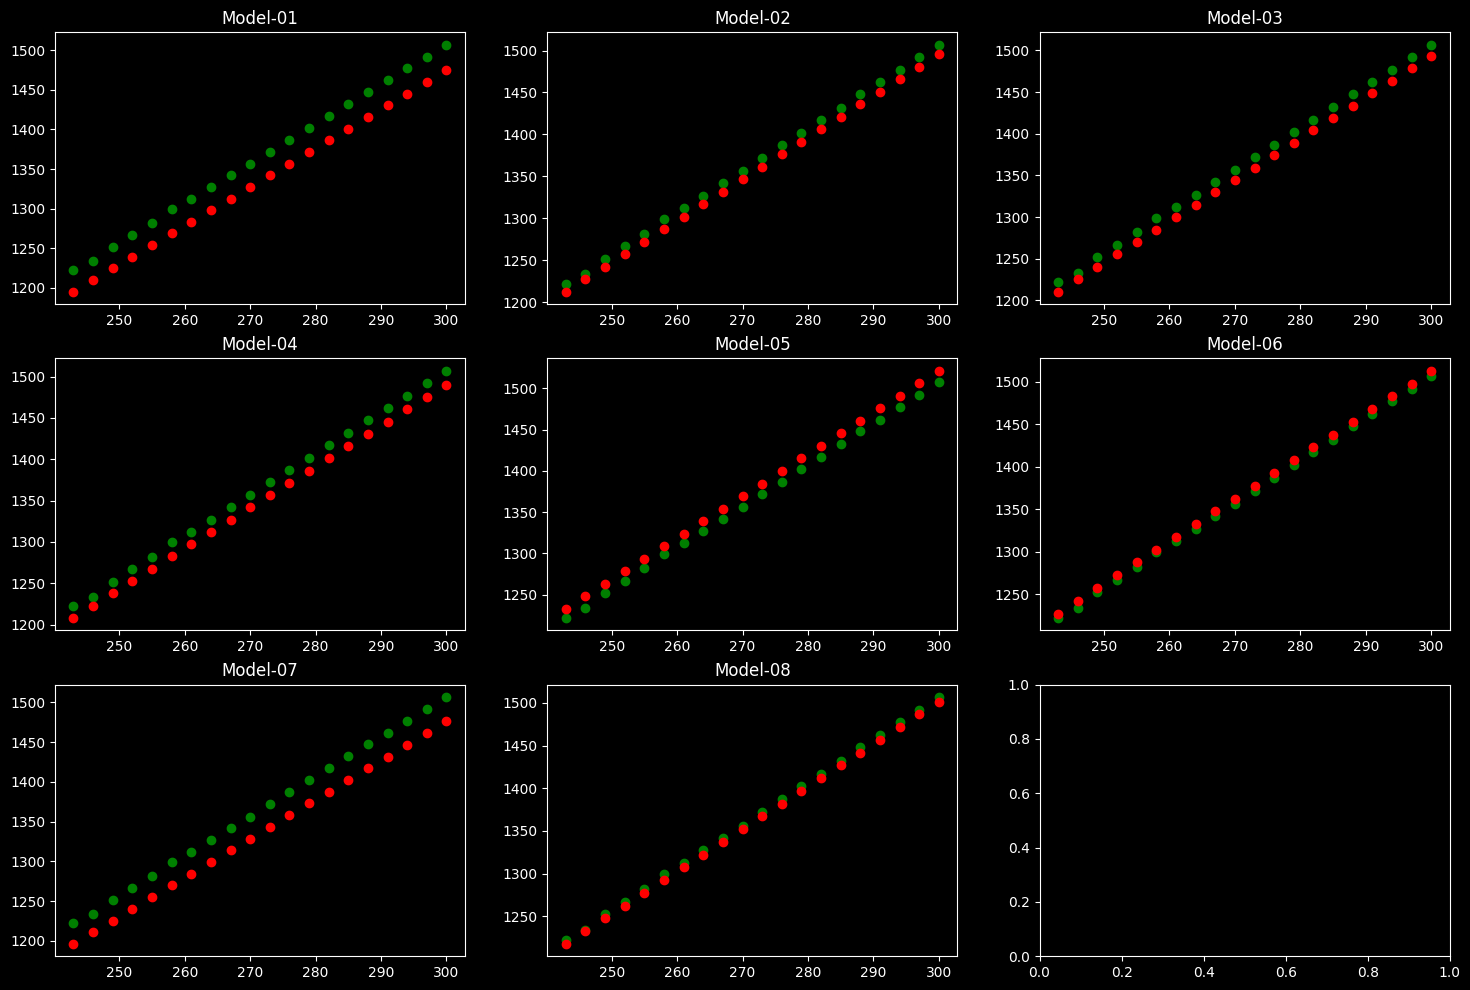

In [20]:
plt.style.use('dark_background')
model_eval.plot_prediction()